### 1.0 Libraries and directories

In [1]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt

os.chdir("/Users/jmaze/Documents/geog590/")

### 2.0 Read and format the SHELDUS data

In [2]:
claims = pd.read_csv('./project_data/SC-claimsA.csv', index_col=False)

# Drop columns which we aren't using
drop_cols = [
    'StateName', 'Fatalities', 'FatalitiesDuration', 'FatalitiesPerCapita', 
    'Glide', 'Injuries', 'InjuriesDuration', 'InjuriesPerCapita', 'PropertyDmgDuration'
]


claims.drop(columns=drop_cols, inplace=True)
# Some of the column names have bad syntax
claims.rename(columns={' Hazard': 'Hazard'}, inplace=True)

claims.head()

,CountyName,Hazard,EventName,StartDate,EndDate,Month,Quarter,Year,Duration_Days,CropDmg,CropDmg(ADJ),CropDmgDuration,CropDmgPerCapita,County_FIPS,Location,PropertyDmg,PropertyDmg(ADJ),PropertyDmgPerCapita,Remarks
0,Abbeville,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45001.0,SCZ001>8-10>13-19,2000000.0,3614167.07,146.44,ICE STORM
1,Anderson,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45007.0,SCZ001>8-10>13-19,2000000.0,3614167.07,22.20,ICE STORM
2,Cherokee,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45021.0,SCZ001>8-10>13-19,2000000.0,3614167.07,72.18,ICE STORM
3,Greenville,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45045.0,SCZ001>8-10>13-19,2000000.0,3614167.07,10.07,ICE STORM
4,Greenwood,Winter Weather,Winter Storm 1999,1999-01-02,1999-01-03,1.0,1.0,1999.0,2.0,0.0,0.0,0.0,0.0,45047.0,SCZ001>8-10>13-19,2000000.0,3614167.07,56.72,ICE STORM


### 3.0 Explore data attributes

In [3]:
hazard_types = claims['Hazard'].unique().tolist()
event_names = claims['EventName'].unique().tolist()
total_dollars = claims['PropertyDmg(ADJ)'].sum()

### 4.0 Plot the claims timeseries

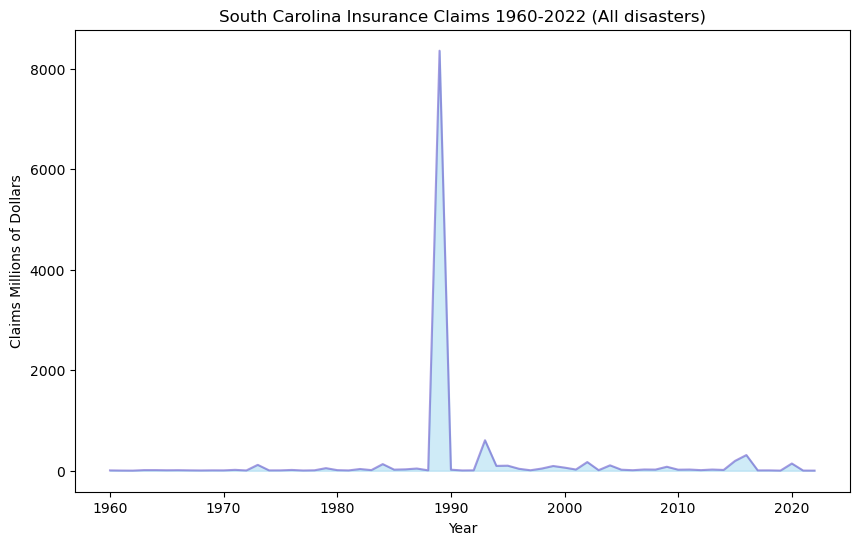

In [4]:
df = claims.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

plt.figure(figsize=(10, 6))
plt.fill_between(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='skyblue', alpha=0.4)
plt.plot(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='Slateblue', alpha=0.6)
plt.title("South Carolina Insurance Claims 1960-2022 (All disasters)")
plt.xlabel("Year")
plt.ylabel("Claims Millions of Dollars")
plt.show()

Clearly we have a few massive outlier events. Let's evaluate their impact by finding the top-5 most expensive disasters. 

In [5]:
worst_events = claims.groupby('EventName').agg({
    'PropertyDmg(ADJ)': 'sum'})

worst_events['percent_all_claims_dollars'] = worst_events['PropertyDmg(ADJ)']/total_dollars * 100
worst_events.sort_values(by='percent_all_claims_dollars', ascending=False, inplace=True)

worst_events.round(2).head()

,PropertyDmg(ADJ),percent_all_claims_dollars
EventName,,
Hurricane 1989 Hugo,8.306397e+09,73.53
Drought/Heatwave 1993 Southeast,5.539581e+08,4.90
Hurricane 2016 Matthew,3.056965e+08,2.71
Flooding 2015 East/SC,1.749534e+08,1.55
Severe Weather/Tornadoes Southeast/East,1.159230e+08,1.03


Wow! Out of the entire claims database, one event (Hurricane Hugo) is responsible for 73.53% of the losses (~ $8.3B adjusted to 2022 inflation). These numbers testify to the outsized impact of mega-events for insurance loss provisions. Insurers need to account for these left-tail (worst-case scenario) outcomes. There's also geographic concentration here. If an insurance company exclusively sold policies in Coastal SC in 1989, they almost certianly be bankrupt unable to pay claims. This is why re-insurance companies like Swiss Re exist! They are an insurance company for the insurance companies designed to diversify geographic concentration risk.

Given my small dataset, I'll need to ignore Hurricane Hugo, because that event obscures all other trends. Given a wider geographic region (beyond SC), I could begin incorperating more outsized events; however, purchasing additional states from SHELDUS is prohibitively expensive. 

#### 4.0 Plot the claims timeseries

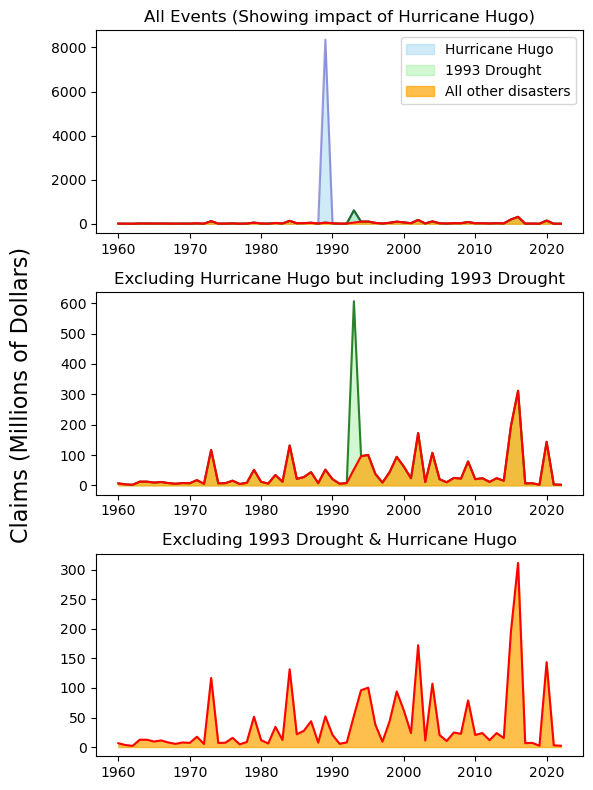

In [13]:
claims2 = claims[claims['EventName'] != "Hurricane 1989 Hugo"]

df2 = claims2.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

claims3 = claims[(claims['EventName'] != "Hurricane 1989 Hugo") & (claims['EventName'] != "Drought/Heatwave 1993 Southeast")]
df3 = claims3.groupby('Year').agg({
    'PropertyDmg(ADJ)': 'sum',
    'Year': 'first'})

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))

#First panel Includes Hugo
axs[0].fill_between(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='skyblue', alpha=0.4, label='Hurricane Hugo')
axs[0].plot(df['Year'], df['PropertyDmg(ADJ)']/1e6, color='Slateblue', alpha=0.6)
axs[0].fill_between(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='lightgreen', alpha=0.4, label='1993 Drought')
axs[0].plot(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='darkgreen', alpha=0.8)
axs[0].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='orange', alpha=0.7, label='All other disasters')
axs[0].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='red', alpha=1)
axs[0].set_title("All Events (Showing impact of Hurricane Hugo)")
axs[0].legend()


# Second panel doesn't include Hugo
axs[1].fill_between(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='lightgreen', alpha=0.4)
axs[1].plot(df2['Year'], df2['PropertyDmg(ADJ)']/1e6, color='darkgreen', alpha=0.8)
axs[1].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='orange', alpha=0.7)
axs[1].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='red', alpha=1)
axs[1].set_title("Excluding Hurricane Hugo but including 1993 Drought")

# Third panel doesn't include Hugo or 1993 Drought
axs[2].fill_between(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='orange', alpha=0.7)
axs[2].plot(df3['Year'], df3['PropertyDmg(ADJ)']/1e6, color='red', alpha=1)
axs[2].set_title("Excluding 1993 Drought & Hurricane Hugo")

#fig.supxlabel('Year', fontsize=16)
fig.supylabel('Claims (Millions of Dollars)', fontsize=16)

plt.tight_layout()
plt.show()